In [1]:
# Loading packages
import PIL
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import random

import torch
import torchvision
import torch.autograd as autograd
import torchvision.transforms as T

## Pretrained Model

For this project, you will use a pre-trained deep neural network, [SqueezeNet](https://arxiv.org/abs/1602.07360), which is lightweight and runs fast on CPUs. Run the code below to load a pre-trained SqueezeNet from the PyTorch official model zoo.

In [2]:
# Test and set the device.
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
print('Use', device)

# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True).to(device)

# Disable the gradient computation with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
cnn = model.features
for layer in list(cnn):
    print(type(layer))

Use cpu
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torchvision.models.squeezenet.Fire'>
<class 'torchvision.models.squeezenet.Fire'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torchvision.models.squeezenet.Fire'>
<class 'torchvision.models.squeezenet.Fire'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torchvision.models.squeezenet.Fire'>
<class 'torchvision.models.squeezenet.Fire'>
<class 'torchvision.models.squeezenet.Fire'>
<class 'torchvision.models.squeezenet.Fire'>


## Data
For Task#1 and Task#2, use the images in folder `Project1\images` where the filenames are the corresponding class labels. For example, `182.png` is an image of Border Terrier, which is class 182 in ImageNet dataset. Please refer to [this Gist snippet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) for a complete list. The images are from ImageNet validation set, and so the pre-trained model has never "seen" them.

For Task#3, you may use the images in folder `Project1\style` or any other images you like.

## Helper Functions

Most pre-trained models are trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. Here are a few helper functions for performing and undoing this preprocessing.

In [3]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def preprocess(img, size=(224, 224)):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN.tolist(),
                    std=IMAGENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / IMAGENET_STD).tolist()),
        T.Normalize(mean=(-IMAGENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

# Task#1 Adversarial Attack

The concept of "image gradients" can be used to study the stability of a network. Consider a state-of-the-art deep neural network that generalizes well on an object recognition task. We expect such network to be robust to small perturbations to its input, because small perturbations cannot change the object category of an image. However, it was shown in the following paper[1] that by applying an imperceptible non-random perturbation to a test image, it is possible to arbitrarily change the network’s prediction.

[1] [Szegedy et al, "Intriguing properties of neural networks", ICLR 2014](https://arxiv.org/abs/1312.6199)

Given an image and a target class, we can perform **gradient ascent** over the image to maximize the target class, stopping when the network classifies the image as the target class. While the perturbations seem negligible to humans, the network would classify the perturbed images wrongly.

Read the paper, and then implement the following function `make_adversarial_attack` to generate "fooling images". For each image in `Project1/images` with class label $c$, generate a fooling image that will be classified into class $ c-1-d $ where $d$ is the last digit of your student number. Save each fooling image into the folder `Project1/fooling_images` with the filename `{true_class}_{target_class}.png`. You may confirm (optional) that the fooling image `182_9.png` in the folder will be wrongly classified as ostrich (class 9 in ImageNet dataset). 

For the image `182.png`, show the difference map between the original image and the fooling image, and save it as `182_1x_diff.png`. Magnify the difference by 10 times and save the resulting map as `182_10x_diff.png`. 

In [4]:
def make_adversarial_attack(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    
    model.eval()
    
    # Initialize our fooling image to the input image
    X_fooling = X.clone().detach()
    X_fooling.requires_grad = True

    # you may change the learning rate and max_iter
    learning_rate = 1

    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    ##############################################################################
    # your code
    ##############################################################################
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam([X_fooling], lr=learning_rate)
    for i in range(3000):  
        Y = torch.tensor([target_y]).to(device)
        outputs = model(X_fooling)
        _, predicted = torch.max(outputs.data, 1)
        if predicted.item() == target_y:
            break
        loss_adv = (X_fooling - X).abs().sum() + loss(outputs, Y)
        optimizer.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer.step()
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    X_fooling = X_fooling.detach()
    
    return X_fooling

Image 85.png is classified as 85
Image 85_83.png is classified as 83
Image 100.png is classified as 437
Image 100_98.png is classified as 98
Image 182.png is classified as 255
Image 182_180.png is classified as 180
Image 294.png is classified as 294
Image 294_292.png is classified as 292
Image 366.png is classified as 366
Image 366_364.png is classified as 364
Image 662.png is classified as 662
Image 662_660.png is classified as 660


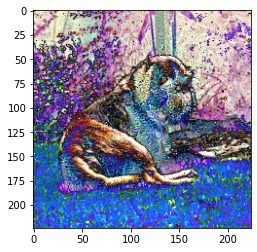

In [5]:
##############################################################################
# TODO: 1. Compute the fooling images for the images under `Project1/images`.#
#       2. Show the 4 related images of the image '182.png': original image, #
#          fooling image, 182_1x_diff.png and 182_10x_diff.png.              #
##############################################################################
# your code
##############################################################################
# My student number A0195041L
d = 1
for true_class in [85, 100, 182, 294, 366, 662]:
    target_class = true_class - 1 - d
    original_file_name = str(true_class) + '.png'
    image = PIL.Image.open('images/' + original_file_name)
    tensor = preprocess(image)
    output = model(tensor.to(device))
    _, predicted = torch.max(output.data, 1)
    print('Image ' + original_file_name + ' is classified as ' + str(predicted.data.numpy()[0]))
    
    ad = make_adversarial_attack(tensor, target_class, model)
    
    deprocessed = deprocess(ad)
    ad_file_name = str(true_class) + '_' + str(target_class) + '.png'
    deprocessed.save('fooling_images/' + ad_file_name)
    output = model(ad.to(device))
    _, predicted = torch.max(output.data, 1)
    print('Image ' + ad_file_name + ' is classified as ' + str(predicted.data.numpy()[0]))
    
    if true_class == 182:
        diff = PIL.ImageChops.difference(deprocessed, image)
        plt.imshow(diff)
        diff.save('182_1x_diff.png')
        for x in range(224):
            for y in range(224):
                pixel = diff.getpixel((x, y))
                new_pixel = (pixel[0] * 10, pixel[1] * 10, pixel[2] * 10)
                diff.putpixel((x, y), new_pixel)
        plt.imshow(diff)
        diff.save('182_10x_diff.png')
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# Task#2 Class Visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[2] [Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman, "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014](https://arxiv.org/abs/1312.6034)

[3] [Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop](https://arxiv.org/abs/1506.06579)


In [6]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
  
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [7]:
def create_class_visualization(target_y, model, device, **kwargs):
    '''
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: A list of two elements, where the first value is an integer in the range [0, 1000) giving the index of the
                class, and the second value is the name of the class.
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    '''
    model.to(device)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    
    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).to(device).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # your code
        ########################################################################
        optimizer = torch.optim.Adam([img], lr=learning_rate)
        Y = torch.tensor([target_y[0]]).to(device)
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        loss = torch.nn.CrossEntropyLoss()
        loss_ = img.abs().sum() + loss(outputs, Y)
        optimizer.zero_grad()
        loss_.backward(retain_graph=True)
        optimizer.step()
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-IMAGENET_MEAN[c] / IMAGENET_STD[c])
            hi = float((1.0 - IMAGENET_MEAN[c]) / IMAGENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = target_y[1]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

Once you have completed the implementation in the cell above, run the following cell to generate an image of a Tarantula:

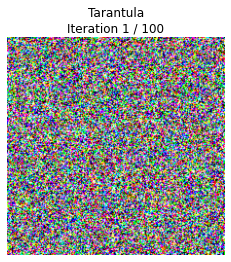

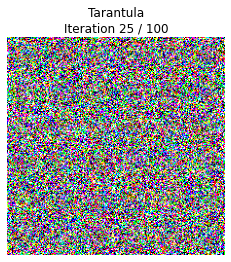

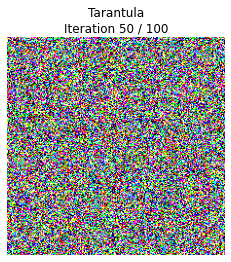

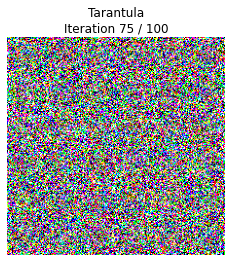

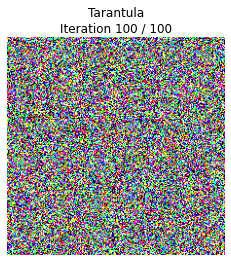

In [8]:
target_y = [76, "Tarantula"]
# target_y = 366 # Gorilla
out = create_class_visualization(target_y, model, device)

# Task#3 Style Transfer

Another task which is closely related to image gradients is style transfer which has become a "cool" application in deep learning for computer vision applications. You need to study and implement the style transfer technique presented in the following paper [4] where the general idea is to take two images (a content image and a style image), and produce a new image that reflects the content of one but the artistic "style" of the other.

[4] [Gatys, Leon A., Alexander S. Ecker, and Matthias Bethge. "Image style transfer using convolutional neural networks." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2016.](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

Below is an example.

![](style_transfer.png)

## Compute the loss

To perform style transfer, you will need to first formulate a special loss function that matches the content and style of each respective image in the feature space, and then perform gradient descent on the pixels of the image itself.

The loss function contains two parts: **content loss** and **style loss**. Read the paper [4] for details about the losses and implement them below.

In [9]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    
    ##############################################################################
    # TODO: Implement content loss function                                      #
    # Note: It should not be very much code (less than 10 lines)                 #
    ##############################################################################
    # your code
    ##############################################################################
    print("content loss")
    current_target = model(content_current)
    print("aaaa")
    original_target = model(content_original)
    print("bbbb")
    loss = nn.MSELoss()(torch.tensor(current_target[0]), torch.tensor(original_target[0]))
    print("cccc")
    return content_weight[0] * loss
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################


def gram_matrix(features):
    """
    Compute the normalized Gram matrix from features.
    The Gram matrix will be used to compute style loss.
    
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    
    Returns:
    - gram: PyTorch Tensor of shape (N, C, C) giving the
      normalized Gram matrices for the N input images.
    """    
    ##############################################################################
    # TODO: Implement the normalized Gram matrix compuation function             #
    # Note: It should not be very much code (less than 10 lines)                 #
    ##############################################################################
    # your code
    ##############################################################################
    n, c, h, w = features.size()
    print('a')
    view = features.view(n, c, h*w)
    print('b')
    result = torch.bmm(view, view.transpose(1, 2))
    result.div_(h*w)
    return result
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################


def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Variable giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    
    ##############################################################################
    # TODO: Implement style loss function                                        #
    # Note: It should not be very much code (less than 10 lines)                 #
    ##############################################################################
    # your code
    ##############################################################################
    result = torch.tensor(0.0)
    gram_matrix_feats = gram_matrix(feats)
    gram_matrix_target = gram_matrix(style_targets)
    loss = nn.MSELoss()(gram_matrix_feats, gram_matrix_target)
    return [style_weights[i] * loss for i in range(4)]
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

## Putting them together

With these loss functions, you can now build your style transfer model. Implement the function below to perform style transfer. To test the model, you can use the content and style images that we have provided in `Project1/style`, or improvise using any image you like. Please save your output images in the `Project1/style` folder.

Design and carry out some experiments (on your own!) to analyse how **the choice of layers** and **the weights** will influence the output image. Write down your observations and analysis in the Markdown cell provided below.

In [10]:
def style_transfer(content_image, style_image, content_layer, content_weight,
                   style_layers, style_weights, max_iter):
    """
    Run style transfer!
    You may first resize the image to a small size for fast computation.
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - content_layer: an index indicating which layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of indices indicating which layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - max_iter: max iterations of gradient updates
    
    Returns:
    - output_image: an image with content from the content_image and 
    style from the style image
    """
    ##############################################################################
    # TODO: Implement the function for style transfer.                           #
    ##############################################################################
    # your code
    ##############################################################################
    print("start")
    content_img = preprocess(PIL.Image.open(content_image)).to(device)
    img = content_img.data.clone().detach()
    style_img = preprocess(PIL.Image.open(style_image)).to(device)
    optimizer = torch.optim.LBFGS([img])
    print("start loop")
    for i in range(max_iter):
        def closure():
            optimizer.zero_grad()
            print('aa')
            layer_loss = style_loss(img, style_layers, style_img, style_weights)
            layer_loss.append(content_loss(content_weight, img, content_img))
            loss = sum(layer_loss)
            loss.backward()
            if i%50 == 49:
                print('Iteration: %d, loss: %f'%(i+1, loss.data[0]))
            return loss
        
        optimizer.step(closure)
    
    return deprocess(img)
        
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ############################################################################## 

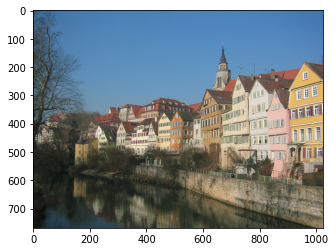

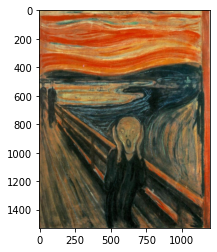

start
start loop
aa
a
b
a
b
content loss
aaaa
bbbb
cccc


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [11]:
##############################################################################
# TODO: 1. Choose one pair of images under 'Project1/style', and finish the  # 
#          neural style transfer task by calling the style_transfer function.#
#       2. Show the 3 related images: content image, style image and the     # 
#          generated style-transferred image.                                #
##############################################################################
# your code
##############################################################################
from torch import nn
# from torch.nn import functional as F
# class VGG(nn.Module):
#         def __init__(self):
#             super(VGG, self).__init__()
#             self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#             self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#             self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#             self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#             self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#             self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
#             self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
#             self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
#             self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#             self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
#             self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
#             self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
#             self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
#             self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
#             self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
#             self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
#             self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#             self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#             self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
#             self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
#             self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
            
#         def forward(self, x, out_keys):
#             out = {}
#             out['0'] = F.relu(self.conv1_1(x))
#             out['1'] = F.relu(self.conv1_2(out['0']))
#             out['2'] = self.pool1(out['1'])
#             out['3'] = F.relu(self.conv2_1(out['2']))
#             out['4'] = F.relu(self.conv2_2(out['3']))
#             out['5'] = self.pool2(out['4'])
#             out['6'] = F.relu(self.conv3_1(out['5']))
#             out['7'] = F.relu(self.conv3_2(out['6']))
#             out['8'] = F.relu(self.conv3_3(out['7']))
#             out['9'] = F.relu(self.conv3_4(out['8']))
#             out['10'] = self.pool3(out['9'])
#             out['11'] = F.relu(self.conv4_1(out['10']))
#             out['12'] = F.relu(self.conv4_2(out['11']))
#             out['13'] = F.relu(self.conv4_3(out['12']))
#             out['14'] = F.relu(self.conv4_4(out['13']))
#             out['15'] = self.pool4(out['14'])
#             out['16'] = F.relu(self.conv5_1(out['15']))
#             out['17'] = F.relu(self.conv5_2(out['16']))
#             out['18'] = F.relu(self.conv5_3(out['17']))
#             out['19'] = F.relu(self.conv5_4(out['18']))
#             out['20'] = self.pool5(out['19'])
#             return [out[key] for key in out_keys]

import os
# vgg = VGG()
# for param in vgg.parameters():
#     param.requires_grad = False
# vgg.to(device)
model.eval()
img_dir = os.getcwd() + '/style/'
content = 'tubingen.jpg'
style = 'the_scream.jpg'
content_image = img_dir + content
plt.imshow(PIL.Image.open(content_image))
plt.show()
style_image = img_dir + style
plt.imshow(PIL.Image.open(style_image))
plt.show()
content_layer = [7]
content_weight = [1e0]
style_layers = [0, 3, 6, 9]
style_weights = [1e3/n**2 for n in [64, 128, 256, 512]]
max_iter = 500
transferred = style_transfer(content_image, style_image, content_layer, content_weight, style_layers, style_weights, max_iter)
plt.imshow(transferred)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**

---